# Synthetic VNF Data

Gen synth data and fit multiple models agains it

In [13]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.base import BaseEstimator
from sklearn.model_selection import KFold, train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import LabelEncoder, StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

%matplotlib inline

sns.set(font_scale=1.2)
sns.set_style("white")

In [14]:
class FixedModel(BaseEstimator):
    """
    sklearn model of the fixed model, 
    always allocating/predicting a fixed, pre-defined amount of resources.
    For use in sklearn functions like k-fold CV
    """
    def __init__(self, fixed_value):
        self.fixed_value = fixed_value
        
    def fit(self, X, y):
        """There's nothing to fit here"""
        return self
    
    def predict(self, X):
        """Always 'predict' the specified fixed value"""
        n_samples = X.shape[0]
        return [self.fixed_value for _ in range(n_samples)]

In [3]:
# define column names
cpu_col = 'Resource req. [e.g., CPU]'
thr_col = 'Traffic load [e.g., Mbit/s]'

In [4]:
# generate synthetic data
def gen_benchmark(cpu, coeff1=1, coeff2=1):
    """Generate max throughput for given CPU time according to log function"""
    return coeff1 * math.log2(1 + coeff2 * cpu)

def synthetic_benchmark():
    """Generate synthetic benchmark results for CPU time 0-100%"""
    cpu_list = np.arange(0.1, 1, .01)
    data = []
    for cpu in cpu_list:
        data.append([cpu, gen_benchmark(cpu, coeff2=100)])
    return pd.DataFrame(data, columns=[cpu_col, thr_col])

# inverse function to calculate cpu given a throughput
def inverse(thru, coeff2=1):
    return (1/coeff2) * (2**thru - 1)

In [5]:
# prepare data
df = synthetic_benchmark()
X = df[[thr_col]]
y = df[cpu_col]

In [11]:
def cross_validation_rmse(model, X, y, k=5, save_model=False):
    """Do k-fold CV and return the avg RMSE on the validation set. Train and save the model."""
    scores = cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=k)
    rmse = np.sqrt(-scores)
    name = type(model).__name__
    print(f"CV RMSE of {name}: {rmse.mean()} (+/-{rmse.std()})")  
    if save_model:
        model.fit(X, y)
        joblib.dump(model, f'ml_models/synth_data/{name}.joblib')
    return rmse 

def barplot_rmse(scores, labels, data_name):
    """bar plot comparing the RMSE of the different algorithms"""
    assert len(scores) == len(labels)
    
    # preparation
    rmse_mean = [s.mean() for s in scores]
    rmse_std = [s.std() for s in scores]
    x = np.arange(len(labels))

    # plot
    fig, ax = plt.subplots()
    plt.bar(x, rmse_mean, color='grey', yerr=rmse_std, capsize=5)

    # labels
    ax.set_xlabel('Machine learning models')
    ax.set_ylabel('RMSE')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    
    fig.savefig(f'plots/{data_name}_rmse.pdf', bbox_inches='tight')

CV RMSE of LinearRegression: 0.12121162713679334 (+/-0.0834142420571489)
CV RMSE of Ridge: 0.1157083036553567 (+/-0.07204672163128789)
CV RMSE of SVR: 0.15772899390054107 (+/-0.08774146778153001)
CV RMSE of RandomForestRegressor: 0.07768014421796737 (+/-0.02677303109989208)
CV RMSE of GradientBoostingRegressor: 0.07805364007331642 (+/-0.025433426403506574)
CV RMSE of MLPRegressor: 0.31430926005271564 (+/-0.07253683490516659)
CV RMSE of FixedModel: 0.30476112171679437 (+/-0.19909124881970067)


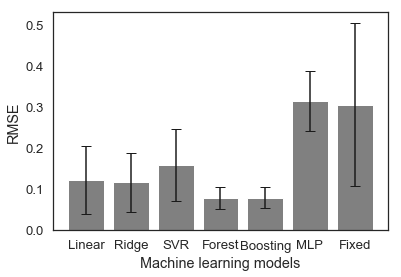

In [22]:
models = [LinearRegression(), Ridge(), SVR(), RandomForestRegressor(), 
          GradientBoostingRegressor(), MLPRegressor(), FixedModel(fixed_value=0.8)]
labels = ['Linear', 'Ridge', 'SVR', 'Forest', 'Boosting', 'MLP', 'Fixed']
rmse = [cross_validation_rmse(model, X, y) for model in models]

barplot_rmse(rmse, labels, 'synth_default')

In [23]:
# scale the data and do again
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

rmse = [cross_validation_rmse(model, X_scaled, y) for model in models]
barplot_rmse(rmse, labels, 'synth_scaled')

In [25]:
# hyperparam space
params_ridge = {'alpha': [0.1, 1, 10]}
params_svr = {'kernel': ['linear', 'poly', 'rbf'], 'C': [1, 10, 100], 
              'epsilon': [0.001, 0.01, 0.1]}



In [40]:
def tune_hyperparams(model, X, y, params):
    """Do grid search CV for hyperparam tuning and return CV RMSE"""
    grid_search = GridSearchCV(model, params, cv=5, scoring="neg_mean_squared_error")
    grid_search.fit(X, y)
#     rmse = np.sqrt(-grid_search.score(X))
    name = type(model).__name__
#     print(f"CV RMSE of {name}: {rmse.mean()} (+/-{rmse.std()})") 
    #return rmse
    
    # get CV score of best 
    idx = grid_search.best_index_
    mean = grid_search.cv_results_['mean_test_score'][idx]
    std = grid_search.cv_results_['std_test_score'][idx]
    print(f"CV RMSE of {name}: {mean} (+/-{std})")

In [41]:
# hyperparam tuning
models = [Ridge(), SVR()]
params = [params_ridge, params_svr]
rmse = [tune_hyperparams(models[i], X_scaled, y, params[i]) for i in range(len(models))]

CV RMSE of Ridge: -0.013047241219700119 (+/-0.01586603701878614)
CV RMSE of SVR: -5.8980529036991834e-05 (+/-9.948384464462288e-05)
